In [ ]:
π

In [1]:
using Pkg
Pkg.add("Plots")
Pkg.add("Interpolations")
Pkg.add("QuadGK")
Pkg.add("Unitful")
Pkg.add("UnitfulAstro")
Pkg.add("Random")
Pkg.add("SpecialFunctions")
Pkg.add("Roots")
Pkg.add("Trapz")
Pkg.add("PhysicalConstants")
Pkg.add("Cosmology")
Pkg.add("DataInterpolations")
Pkg.add("MeshGrid")
Pkg.add("PlotlyJS")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed JpegTurbo_jll ──────────────── v3.1.1+0
   Installed libdecor_jll ───────────────── v0.2.2+0
   Installed GR_jll ─────────────────────── v0.73.14+0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed libfdk_aac_jll ─────────────── v2.0.3+0
   Installed Libmount_jll ───────────────── v2.41.0+0
   Installed LERC_jll ───────────────────── v4.0.1+0
   Installed LoggingExtras ──────────────── v1.1.0
   Installed Opus_jll ───────────────────── v1.3.3+0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.7+0
   Installed RelocatableFolders ─────────── v1.0.1
   Installed Measures ───────────────────── v0.3.2
   Installed Unitful ────────────────────── v1.22.1
   Installed Contour ────────────────────── v0.6.3
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed Grisu ──────────────────────── v1.0.2
   Installed ConcurrentUtilities ────────── v2.5.0
   Installed Xor

In [2]:
using Plots 
using Interpolations
using QuadGK
using Unitful, UnitfulAstro
using Random
using SpecialFunctions
using Roots
using Trapz
using PhysicalConstants
using Cosmology
using MeshGrid
import DataInterpolations 

In [3]:
import PhysicalConstants.CODATA2018 as constants
const M_sun = 1.98847e30u"kg"
const T_cmb =  2.725 * u"K"
const P_e_factor = constants.σ_e / (constants.m_e * constants.c_0^2)

8.125531675591423e-16 s^2 kg^-1

In [4]:
abstract type AbstractProfileWorkspace{T} end
abstract type AbstractProfile{T} end
abstract type AbstractGNFW{T} <: AbstractProfile{T} end
abstract type AbstractInterpolatorProfile{T} <: AbstractProfile{T} end

struct Battaglia16ThermalSZProfile{T,C} <: AbstractGNFW{T}
    f_b::T
    cosmo::C
end



function Battaglia16ThermalSZProfile(; Omega_c::T=0.2589, Omega_b::T=0.0486, h::T=0.6774) where {T <: Real}
    OmegaM=Omega_b+Omega_c
    f_b = Omega_b / OmegaM
    cosmo = get_cosmology(T, h=h, OmegaM=OmegaM)
    return Battaglia16ThermalSZProfile(f_b, cosmo)
end

function get_params(::AbstractGNFW{T}, M_200, z) where T
	z₁ = z + 1
	m = M_200 / (1e14M_sun)
	P₀ = 18.1 * m^0.154 * z₁^-0.758
	xc = 0.497 * m^-0.00865 * z₁^0.731
	β = 4.35 * m^0.0393 * z₁^0.415
	α = 1
    γ = -0.3
    β = γ - α * β  # Sigurd's conversion from Battaglia to standard NFW
    return (xc=T(xc), α=T(α), β=T(β), γ=T(γ), P₀=T(P₀))
end

get_params (generic function with 1 method)

In [170]:
function get_cosmology(::Type{T}; h=0.69,
                   Neff=3.04,
                   OmegaK=0.0,
                   OmegaM=0.29,
                   OmegaR=nothing,
                   Tcmb=2.7255,
                   w0=-1,
                   wa=0) where T

    if OmegaR === nothing
        OmegaG = 4.48131e-7*Tcmb^4/h^2
        OmegaN = Neff*OmegaG*(7/8)*(4/11)^(4/3)
        OmegaR = OmegaG + OmegaN
    end

    OmegaL = 1 - OmegaK - OmegaM - OmegaR

    if !(w0 == -1 && wa == 0)
        return Cosmology.WCDM{T}(h, OmegaK, OmegaL, OmegaM, OmegaR, w0, wa)
    end

    if OmegaK < 0
        return Cosmology.ClosedLCDM{T}(h, OmegaK, OmegaL, OmegaM, OmegaR)
    elseif OmegaK > 0
        return Cosmology.OpenLCDM{T}(h, OmegaK, OmegaL, OmegaM, OmegaR)
    else
        return Cosmology.FlatLCDM{T}(h, OmegaL, OmegaM, OmegaR)
    end
end
get_cosmology(; h=0.69, Neff=3.04, OmegaK=0.0, OmegaM=0.29, OmegaR=nothing, Tcmb=2.7255, 
    w0=-1, wa=0) = get_cosmology(Float32; h=h, Neff=Neff, OmegaK=OmegaK, 
        OmegaM=OmegaM, OmegaR=OmegaR, Tcmb=Tcmb, w0=w0, wa=wa)


function ρ_crit(model, z)
    H_z = H(model.cosmo, z)
    return uconvert(u"kg/m^3", 3H_z^2 / (8π * constants.G))
end

function R_Δ(model, M_Δ, z, Δ=200)
    return ∛(M_Δ / (4π/3 * Δ * ρ_crit(model, z)))
end

function angular_size(model::AbstractProfile{T}, physical_size, z) where T
    d_A = angular_diameter_dist(model.cosmo, z)

    # convert both to the same units and strip units for atan
    phys_siz_unitless = @. T.(ustrip.(uconvert.(unit(d_A), physical_size)))
    d_A_unitless = T(ustrip(d_A))
    return atan.(phys_siz_unitless, d_A_unitless)
end

function build_z2r_interpolator(min_z::T, max_z::T,
    cosmo::Cosmology.AbstractCosmology; n_bins=2000) where T

    zrange = LinRange(min_z, max_z, n_bins)
    rrange = zero(zrange)
    for i in 1:n_bins
        rrange[i] = ustrip(T, u"Mpc",
            Cosmology.comoving_radial_dist(u"Mpc", cosmo, zrange[i]))
    end
    z2r = DataInterpolations.LinearInterpolation(rrange, zrange);
    return z2r
end

function δαz2gnom(cosmo::Cosmology.AbstractCosmology, z2r::DataInterpolations.LinearInterpolation,
    δ, α, z; δ₀ = 0., α₀ = 0., ΔZ = 5e-6, NZ::Int = 500)
    χ₀ = z2r(z)
    Dₐ = angular_diameter_dist(cosmo,z)
    χ₁, χ₂ = z2r(z - ΔZ), z2r(z + ΔZ)
    Z̃ = collect(range(χ₁ -  χ₀, χ₂ - χ₀, length=length(δ)))u"Mpc"
    C̃ = @.cos(δ₀)*cos(δ)*cos(α - α₀) + sin(δ)*sin(δ₀)
    X̃ = @. Dₐ*(cos(δ)*sin(α - α₀))/C̃
    Ỹ = @. Dₐ*(sin(δ₀)*cos(δ)*cos(α - α₀) - cos(δ₀)*sin(δ))/C̃
    X̃ = uconvert.(u"m", X̃)
    Ỹ = uconvert.(u"m", Ỹ)
    Z̃ = uconvert.(u"m", Z̃)
    return X̃, Ỹ, Z̃
end

function rotation_matrix(ϕ, θ, ψ)
    R_z1 = [cos(ϕ) -sin(ϕ) 0;
            sin(ϕ)  cos(ϕ) 0;
            0       0      1]
    R_x = [1  0         0;
           0  cos(θ) -sin(θ);
           0  sin(θ)  cos(θ)]
    R_z2 = [cos(ψ) -sin(ψ) 0;
            sin(ψ)  cos(ψ) 0;
            0       0      1]
    return R_z1 * R_x * R_z2
end

function get_coords(δ, α, z, δ₀, α₀, 
        cosmo::Cosmology.AbstractCosmology; 
        ϕ = 0, θ = 0, ψ = 0, ϵ₁ = 0, ϵ₂ = 0, ΔZ = 1e-6, 
        z2r::Union{DataInterpolations.LinearInterpolation, Nothing} = nothing, full = false)
    R_rot = rotation_matrix(ϕ, θ, ψ)
    if z2r === nothing
        z2r = build_z2r_interpolator(1e-10, 5., cosmo)
    end
    x,y,z = δαz2gnom(cosmo, z2r, δ, α, z; δ₀ =  δ₀, α₀ = α₀, ΔZ = ΔZ)
    xs, ys, zs = vec(x), vec(y), vec(z)
    v⃗ = [xs'; ys'; zs']
    v⃗′ = R_rot * v⃗
    x′ = v⃗′[1, :]
    y′ = v⃗′[2, :]
    z′ = v⃗′[3, :]

    X,Y,Z = meshgrid(x′, y′, z′)  
    print(minimum(Z), "\n")
    print(maximum(Z), "\n")
    R = @. sqrt(X^2 + Y^2/((1 - ϵ₁)^2) + Z^2/((1 - ϵ₂)^2))
    if full == true
        return R, x′, y′, z′
    else
        return R
    end
end

function generalized_nfw(x, xc, α, β, γ)
    x̄ = x / xc
    return x̄^γ * (1 + x̄^α)^((β - γ) / α)
end

function _generalized_scaled_nfw(x̄, α, β, γ)
    return x̄^γ * (1 + x̄^α)^((β - γ) / α)
end

function _nfw_profile_los_quadrature(x, xc, α, β, γ; zmax=1e5, rtol=eps(), order=9)
    x² = x^2
    scale = 1e9
    integral, err = quadgk(y -> scale * generalized_nfw(√(y^2 + x²), xc, α, β, γ),
                      0.0, zmax, rtol=rtol, order=order)
    return 2integral / scale
end


_nfw_profile_los_quadrature (generic function with 1 method)

In [171]:
function ycompton(model::Battaglia16ThermalSZProfile{T}, θ, M, z; θ_physical = true, 
        Zlos::Any = nothing, return_3D = false) where T
    factor = constants.G * M * 200 * ρ_crit(model, z) * model.f_b / 2 * 0.5176
    R_200 = R_Δ(model, M, z, 200)
    par = get_params(model, M, z)
    θ = θ_physical == true ? angular_size(model, θ, z) : θ
    Zlos = θ_physical == true ? angular_size(model, Zlos, z) : Zlos
    x = θ_physical == true ? θ / angular_size(model ,R_200, z) : θ / R_200
    if ndims(θ) == 1
        P = @. par.P₀ * _nfw_profile_los_quadrature(x, par.xc, par.α, par.β, par.γ)
        return P
    elseif ndims(θ) == 3 && Zlos !== nothing
        P₀, xc, α, β, γ = par.P₀, par.xc, par.α, par.β, par.γ 
        P3D = @. P₀ * ((x/xc)^γ) * (1  + (x/xc)^α)^((β - γ) / α)
        projected_P = trapz((:,:,Zlos), P3D)
        if return_3D == false
            return projected_P
        else
            return P3D
        end
    end
end

ycompton (generic function with 1 method)

-2.797471635505444e24 m
2.797471635505444e24 m


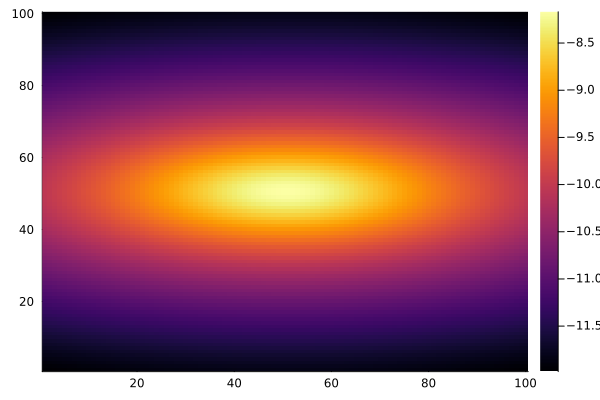

In [179]:
δ = [deg2rad(v) for v in collect(range(-5, 5, length = 100))]
α = [deg2rad(v) for v in collect(range(-5, 5, length = 100))]
δ₀ = deg2rad(0)
α₀ = deg2rad(0)
z = 0.35
cosmo = cosmology()
M = 1e15M_sun
model = Battaglia16ThermalSZProfile()
z2r_interpolator = build_z2r_interpolator(1e-5, 5., cosmo)
R, X, Y, Zlos = get_coords(δ, α, z, δ₀, α₀,cosmo; ϕ = deg2rad(90.), θ = deg2rad(90.), 
    ψ = deg2rad(90.), z2r = z2r_interpolator, full = true, ϵ₁ = .0 , ϵ₂ = 0.95, ΔZ = 1e-2);
ymap = ycompton(model, R, M, z; Zlos = Zlos, return_3D = false);
heatmap(log10.(ymap))

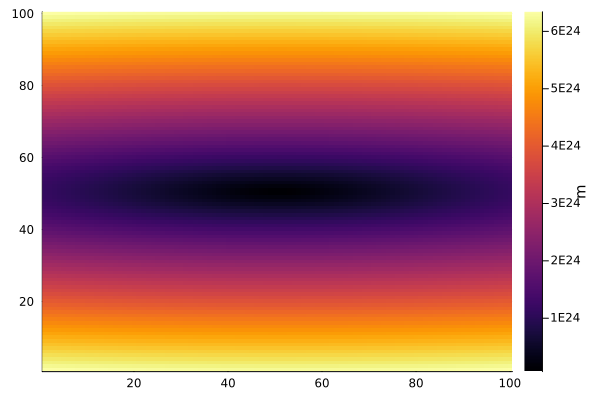

In [163]:
heatmap(R[:, 50, :])

In [13]:
abstract type AbstractRotationMatrix{T} end

struct RotationEulerMatrix{T} <: AbstractRotationMatrix{T}
    ϕ::T
    θ::T
    ψ::T
    R::Matrix{T}
end


function rotation_matrix(ϕ, θ, ψ) where T
    R_z1 = [cos(ϕ) -sin(ϕ) 0;
            sin(ϕ)  cos(ϕ) 0;
            0       0      1]
    R_x = [1  0         0;
           0  cos(θ) -sin(θ);
           0  sin(θ)  cos(θ)]
    R_z2 = [cos(ψ) -sin(ψ) 0;
            sin(ψ)  cos(ψ) 0;
            0       0      1]
    return RotationEulerMatrix(ϕ=T(ϕ), θ=θ, ψ=ψ, 
        R = R_z1 * R_x * R_z2)
end

rotation_matrix(0.45, 0.45, 0.45)

LoadError: UndefVarError: `T` not defined in static parameter matching
Suggestion: run Test.detect_unbound_args to detect method arguments that do not fully constrain a type parameter.

In [23]:
abstract type AbstractRotationMatrix{T} end

"""
    RotationEulerMatrix(phi, theta, psi)

A rotation matrix from Z–X–Z Euler angles (ϕ, θ, ψ), stored as a 3×3 `Matrix{T}`.
"""
struct RotationEulerMatrix{T} <: AbstractRotationMatrix{T}
    ϕ::T
    θ::T
    ψ::T
    R::Matrix{T}      # now a 3×3 matrix, not a scalar
end

# Inner constructor that computes R from the angles:
function RotationEulerMatrix(ϕ::T, θ::T, ψ::T) where T<:Real
    # First Z-rotation
    R_z1 = [ cos(ϕ)  -sin(ϕ)   0;
                       sin(ϕ)   cos(ϕ)   0;
                         0         0     1 ]
    # X-rotation
    R_x  = [ 1      0          0;
                      0  cos(θ)  -sin(θ);
                      0  sin(θ)   cos(θ) ]
    # Second Z-rotation
    R_z2 = [ cos(ψ)  -sin(ψ)  0;
                      sin(ψ)   cos(ψ)  0;
                        0         0    1 ]
    R = R_z1 * R_x * R_z2

    return RotationEulerMatrix{T}(ϕ, θ, ψ, Matrix{T}(R))
end

# A convenience method to extract the matrix:
rotation_matrix(m::RotationEulerMatrix) = m.R
m = RotationEulerMatrix(0.45, 0.45, 0.45)
R = rotation_matrix(m)

3×3 Matrix{Float64}:
 0.640445  -0.744336   0.189195
 0.744336   0.540892  -0.391663
 0.189195   0.391663   0.900447

In [ ]:
function get_params(::AbstractGNFW{T}, M_200, z) where T
	z₁ = z + 1
	m = M_200 / (1e14M_sun)
	P₀ = 18.1 * m^0.154 * z₁^-0.758
	xc = 0.497 * m^-0.00865 * z₁^0.731
	β = 4.35 * m^0.0393 * z₁^0.415
	α = 1
    γ = -0.3
    β = γ - α * β  # Sigurd's conversion from Battaglia to standard NFW
    return (xc=T(xc), α=T(α), β=T(β), γ=T(γ), P₀=T(P₀))